In [1]:
from plotting_utils import plot_movement_trajectory_with_layout
import os

heartbeat_dir = os.path.join('EK_P02', 'Electrophysiology', 'VR', 'BBT-BIO-AAB023-2024-06-18_12-53-55')
heartbeat_path = os.path.join(heartbeat_dir, 'ExG [1].csv')
utc_path = os.path.join(heartbeat_dir, 'UTC.csv')

movement_dir = os.path.join('EK_P02', 'VR', 'pilot final', 'S001', 'trackers')
movement_path = os.path.join(movement_dir, 'camera_movement_T011.csv')

time     0.012141
pos_x    0.002013
pos_y    0.000766
pos_z    0.003151
rot_x    0.244414
rot_y    0.370196
rot_z    0.129838
dist     0.004246
speed    0.352737
dtype: float64
time     0.012058
pos_x    0.003090
pos_y    0.001082
pos_z    0.004973
rot_x    0.310271
rot_y    0.487908
rot_z    0.148348
dist     0.006583
speed    0.548725
dtype: float64
(15527, 2)


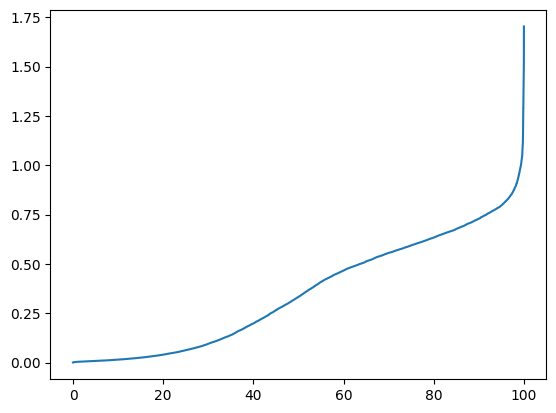

In [2]:
from calculations import calculate_total_rotation, df_diff
import pandas as pd
import numpy as np
from geometry_utils import get_ellipsoid_axes, get_focus, get_eccentricity, get_focus_and_eccentricity

movement_data = pd.read_csv(movement_path).drop("timestamp", axis=1)
diff_frame = df_diff(movement_data)
diff_frame["dist"] = np.sqrt(diff_frame["pos_x"].pow(2) + diff_frame["pos_y"].pow(2) + diff_frame["pos_z"].pow(2))
diff_frame["speed"] = diff_frame["dist"] / diff_frame["time"]
print(diff_frame.mean())
import matplotlib.pyplot as plt
y = np.sort(diff_frame["speed"])
x = 100*np.arange(len(y))/len(y)

print(diff_frame[diff_frame["speed"] > 0.2].mean())
plt.plot(x,y)

points = np.transpose(np.stack((movement_data['pos_x'], movement_data['pos_z'])), axes=[1,0])
print(points.shape)

#print(get_focus_and_eccentricity(points))


In [4]:
import numpy as np
from geometry_utils import mean_edge_distance, mean_center_distance

center_point = np.array((-7,5))
corner_points = np.array([(-4,2),(-9,2),(-9,9),(-4,9)])

print(mean_center_distance(points, center_point))
print(mean_edge_distance(points, corner_points))

1.949148276661069
0.7255100369994726


In [12]:
from biosppy.signals.tools import filter_signal
import pandas as pd
import biosppy.signals.ecg as ecg
import numpy as np
from shapely.geometry import Point, LineString
from shapely.geometry import Polygon
from geometry_utils import mean_center_distance, mean_edge_distance, dist

In [ ]:
def get_segment(data, start_time, end_time, timestamps):
    segment_points = data[np.logical_and(timestamps >= start_time, 
                                         timestamps < end_time)]
    return segment_points

def setup_platform_areas():
    """Set up platform areas with outer and inner boundaries"""
    # Create polygons for the platform borders
    outer_platform = Polygon([
        (-4.83, 1.89), (-5.46, 1.71), (-5.74, 2.84), (-6.32, 2.68),
        (-6.81, 4.40), (-7.39, 4.24), (-8.05, 6.47), (-5.11, 7.31),
        (-4.45, 5.06), (-5.03, 4.90), (-4.56, 3.17), (-5.14, 3.01)
    ])
    
    inner_platform = Polygon([
        (-6.00, 3.26), (-6.49, 4.98), (-7.07, 4.82), (-7.47, 6.15),
        (-5.43, 6.73), (-5.03, 5.38), (-5.60, 5.23), (-5.13, 3.50)
    ])
    
    return outer_platform, inner_platform

def check_position_safety(x, z, outer_platform, inner_platform):
    """
    Determine if a position is in safe, unsafe, or outside area
    
    Returns:
    -1: outside platform
    0: unsafe area (between outer and inner)
    1: safe area (inside inner platform)
    """
    point = Point(x, z)
    
    if not point.within(outer_platform):
        return -1  # Outside platform
    elif point.within(inner_platform):
        return 1   # Safe area
    else:
        return 0   # Unsafe area

def get_segment_safety_analysis(segment, outer_platform, inner_platform):
    """Analyze segment for time spent in each area"""
    total_points = len(segment)
    safe_points = 0
    unsafe_points = 0
    outside_points = 0
    
    for _, row in segment.iterrows():
        safety = check_position_safety(row['pos_x'], row['pos_z'], outer_platform, inner_platform)
        if safety == 1:
            safe_points += 1
        elif safety == 0:
            unsafe_points += 1
        else:
            outside_points += 1
    
    return {
        'safe_percentage': (safe_points / total_points) * 100,
        'unsafe_percentage': (unsafe_points / total_points) * 100,
        'outside_percentage': (outside_points / total_points) * 100
    }

# Modified version of your feature functions:
def get_segment_stops_duration_platform(movement_segment, outer_platform, inner_platform, 
                                      stop_threshold=0.10, stop_duration_threshold=2.0):
    """Calculate stops duration categorized by platform areas"""
    diff_df = movement_segment.drop('timestamp', axis=1).diff(axis=0)
    diff_df["dist"] = np.sqrt(diff_df["pos_x"].pow(2) + diff_df["pos_y"].pow(2) + diff_df["pos_z"].pow(2))
    speeds = diff_df['dist']/diff_df['time']
    
    time = movement_segment['time'].to_numpy()
    
    safe_stops = []
    unsafe_stops = []
    outside_stops = []
    current_stop_start = None
    
    for i, (speed, (_, row)) in enumerate(zip(speeds, movement_segment.iterrows())):
        if speed < stop_threshold:
            if current_stop_start is None:
                current_stop_start = time[i]
                stop_position = (row['pos_x'], row['pos_z'])
        else:
            if current_stop_start is not None:
                stop_duration = time[i] - current_stop_start
                if stop_duration >= stop_duration_threshold:
                    safety = check_position_safety(stop_position[0], stop_position[1], 
                                                outer_platform, inner_platform)
                    if safety == 1:
                        safe_stops.append(stop_duration)
                    elif safety == 0:
                        unsafe_stops.append(stop_duration)
                    else:
                        outside_stops.append(stop_duration)
                current_stop_start = None
    
    return {
        'safe_stops_duration': sum(safe_stops) if safe_stops else 0,
        'unsafe_stops_duration': sum(unsafe_stops) if unsafe_stops else 0,
        'outside_stops_duration': sum(outside_stops) if outside_stops else 0
    }

def get_segment_mean_center_dist_platform(segment, outer_platform, inner_platform):
    """
    Calculate mean distance to center separately for safe, unsafe, and outside platform areas
    """
    # transform points into np array of dimension [N, 2]
    points = np.transpose(np.stack((segment['pos_x'], segment['pos_z'])), axes=[1,0])
    center_point = np.array((-7,5))
    
    # Calculate distances for all points
    distances = dist(points, center_point)
    
    safe_center_dist = []
    unsafe_center_dist = []
    outside_center_dist = []
    
    # Iterate through points and their distances
    for point, distance in zip(points, distances):
        safety = check_position_safety(point[0], point[1], outer_platform, inner_platform)
        
        if safety == 1:  # Safe area (inner platform)
            safe_center_dist.append(distance)
        elif safety == 0:  # Unsafe area (between platforms)
            unsafe_center_dist.append(distance)
        else:  # Outside platforms
            outside_center_dist.append(distance)
    
    # Handle cases where there might be no points in a category
    safe_mean = np.mean(safe_center_dist) if safe_center_dist else np.nan
    unsafe_mean = np.mean(unsafe_center_dist) if unsafe_center_dist else np.nan
    outside_mean = np.mean(outside_center_dist) if outside_center_dist else np.nan
    
    return {
        'safe_mean_center_dist': safe_mean,
        'unsafe_mean_center_dist': unsafe_mean,
        'outside_mean_center_dist': outside_mean
    }

def get_segment_mean_edge_dist_platform(segment, corner_points, outer_platform, inner_platform):
    """
    Calculate mean edge distance separately for safe, unsafe, and outside platform areas
    """
    # transform points into np array of dimension [N, 2]
    points = np.transpose(np.stack((segment['pos_x'], segment['pos_z'])), axes=[1,0])
    
    # Calculate distances for all points
    distances = mean_edge_distance(points, corner_points)
    
    safe_edge_dist = []
    unsafe_edge_dist = []
    outside_edge_dist = []
    
    # Iterate through points and their distances
    for point, distance in zip(points, distances):
        safety = check_position_safety(point[0], point[1], outer_platform, inner_platform)
        
        if safety == 1:  # Safe area (inner platform)
            safe_edge_dist.append(distance)
        elif safety == 0:  # Unsafe area (between platforms)
            unsafe_edge_dist.append(distance)
        else:  # Outside platforms
            outside_edge_dist.append(distance)
    
    # Handle cases where there might be no points in a category
    safe_mean = np.mean(safe_edge_dist) if safe_edge_dist else np.nan
    unsafe_mean = np.mean(unsafe_edge_dist) if unsafe_edge_dist else np.nan
    outside_mean = np.mean(outside_edge_dist) if outside_edge_dist else np.nan
    
    return {
        'safe_mean_edge_dist': safe_mean,
        'unsafe_mean_edge_dist': unsafe_mean,
        'outside_mean_edge_dist': outside_mean
    }

def calculate_time_in_areas(segment, outer_platform, inner_platform):
    """
    Calculate time spent in safe, unsafe, and outside areas.
    Assumes segment contains 'pos_x', 'pos_z', and 'time' columns.
    """
    time_in_safe_area = 0
    time_in_unsafe_area = 0
    time_in_outside_area = 0
    
    times = segment['time'].values
    
    for i in range(1, len(segment)):
        time_diff = times[i] - times[i-1]
        safety = check_position_safety(
            segment['pos_x'].iloc[i], 
            segment['pos_z'].iloc[i], 
            outer_platform, 
            inner_platform
        )
        
        if safety == 1:  # Safe area (inner platform)
            time_in_safe_area += time_diff
        elif safety == 0:  # Unsafe area (between platforms)
            time_in_unsafe_area += time_diff
        else:  # Outside platforms
            time_in_outside_area += time_diff
            
    return {
        'time_in_safe_area': time_in_safe_area,
        'time_in_unsafe_area': time_in_unsafe_area,
        'time_in_outside_area': time_in_outside_area
    }


# In your main analysis loop:
outer_platform, inner_platform = setup_platform_areas()

segment_length=10
step_size=1

# heart rate data 
#heart_rate_data
movement_data = pd.read_csv(movement_path)

timestamps = pd.to_datetime(movement_data['timestamp']).apply(lambda x: x.timestamp()).astype(int).to_numpy()

start_time = np.floor(np.min(timestamps))

end_time = start_time + 90 #for elevated platofrm it should be bigger than that
segment_starts = np.arange(start_time, end_time-segment_length+1, step=step_size)
segment_ends = segment_starts + segment_length

segment_safe_percentage= np.zeros(len(segment_starts))
segment_unsafe_percentage=np.zeros(len(segment_starts))
segment_outside_percentage = np.zeros(len(segment_starts))

segment_safe_stops= np.zeros(len(segment_starts))
segment_unsafe_stops= np.zeros(len(segment_starts))
segment_outside_stops = np.zeros(len(segment_starts))

segment_safe_mean_center_dist = np.zeros(len(segment_starts))
segment_unsafe_mean_center_dist= np.zeros(len(segment_starts)
                                          )
segment_safe_mean_edge_dist=np.zeros(len(segment_starts))
segment_unsafe_mean_edge_dist=np.zeros(len(segment_starts))

segment_safe_time_spent = np.zeros(len(segment_starts))
segment_unsafe_time_spent = np.zeros(len(segment_starts))

for idx, (start, end) in enumerate(zip(segment_starts, segment_ends)):
    movement_segment = get_segment(movement_data, start, end, timestamps)
    
    # Get safety analysis
    safety_analysis = get_segment_safety_analysis(movement_segment, outer_platform, inner_platform)
    stops_analysis = get_segment_stops_duration_platform(movement_segment, outer_platform, inner_platform)
    mean_center_distance_cal = get_segment_mean_center_dist_platform(movement_segment, outer_platform, inner_platform)
    # Store results
    segment_safe_percentage[idx] = safety_analysis['safe_percentage']
    segment_unsafe_percentage[idx] = safety_analysis['unsafe_percentage']
    segment_outside_percentage[idx] = safety_analysis['outside_percentage']
    
    segment_safe_stops[idx] = stops_analysis['safe_stops_duration']
    segment_unsafe_stops[idx] = stops_analysis['unsafe_stops_duration']
    segment_outside_stops[idx] = stops_analysis['outside_stops_duration']

    segment_safe_mean_center_dist[idx] = mean_center_distance_cal['safe_mean_center_dist']
    segment_unsafe_mean_center_dist[idx] = mean_center_distance_cal['unsafe_mean_center_dist']

    mean_edge_dist_cal = get_segment_mean_edge_dist_platform(movement_segment, corner_points, outer_platform, inner_platform)
    segment_safe_mean_edge_dist[idx] = mean_edge_dist_cal['safe_mean_edge_dist']
    segment_unsafe_mean_edge_dist[idx] = mean_edge_dist_cal['unsafe_mean_edge_dist']

    mean_time_spent_cal=calculate_time_in_areas(movement_segment, outer_platform, inner_platform)
    segment_safe_time_spent[idx] = mean_time_spent_cal['time_in_safe_area']
    segment_unsafe_time_spent[idx] = mean_time_spent_cal['time_in_unsafe_area']


In [10]:
segment_safe_stops

array([2.2582, 2.2582, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    ])

In [11]:
segment_unsafe_stops

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
segment_safe_mean_center_dist

array([1.16098363, 1.15733921, 1.13980238, 1.10499794, 1.04593423,
       0.97815665, 0.94199354, 0.90121908, 0.9518862 , 0.92711078,
       0.89589552, 0.85203331, 0.81519683, 0.80755111, 1.01500769,
       1.81834507, 1.81834507, 1.85312832,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 2.13817049, 2.02460282, 1.99193955,
       1.93181119, 1.94412496, 1.94412496, 1.94412496, 1.94412496,
       1.89594994, 1.7750341 , 1.53478629, 1.29467007, 1.26973888,
       1.1654137 , 1.12543723, 1.12543723, 1.12543723, 1.12543723,
       0.99677801, 0.91777072, 1.00357818, 1.57674207, 1.66859449,
       1.84266772,        nan,        nan,        nan,        nan,
       2.12985521, 1.93928962, 1.93928962, 1.90379864, 1.90732178,
       1.95304505, 1.95304505, 1.95304505, 1.94314286, 1.9063596 ,
       1.8703453 , 1.83382336, 1.80753989, 1.8060839 , 1.74688965,
       1.63551125, 1.55447012, 1.50012919, 1.48147984, 1.43769

In [16]:
segment_unsafe_mean_center_dist

array([       nan,        nan,        nan,        nan,        nan,
       0.32018511, 0.58206021, 0.86588125, 1.01345216, 1.44687593,
       1.80479174, 2.11520073, 2.24226978, 2.24226978, 2.35347826,
       2.58147785, 2.9079415 , 3.18675694, 3.24093989, 3.44027488,
       3.58346019, 3.58903679, 3.54467178, 3.53277658, 3.5257757 ,
       3.45222855, 3.32840318, 3.28158725, 3.16491297, 2.98473372,
       2.91430391, 2.81495562, 2.60061881, 2.4563913 , 2.2692507 ,
       2.12644937, 2.02870049, 2.01194596, 2.04423303, 1.75321879,
       1.66198678, 1.66392796, 1.73102017, 1.9279854 , 2.20093669,
       2.39570502, 2.6028664 , 2.7490271 , 2.85803689, 3.19493092,
       3.33649011, 3.35320012, 3.49566105, 3.58000707, 3.49970058,
       3.35758421, 3.30585707, 2.92597471, 2.64986676, 2.4255236 ,
       2.40565439, 2.36047355, 2.36047355, 2.20972762, 2.00675248,
       1.89572357, 1.89615168, 1.96563277, 1.91150106, 1.900002  ,
       1.88234939, 1.76235947, 1.59504314, 1.19173414, 1.12258

In [12]:
def get_segment_speed_platform(movement_data, outer_platform, inner_platform):
    """
    Calculate mean speed separately for safe, unsafe, and outside platform areas
    """
    # Calculate speeds
    diff_df = movement_data.drop('timestamp', axis=1).diff(axis=0)
    diff_df["dist"] = np.sqrt(diff_df["pos_x"].pow(2) + diff_df["pos_y"].pow(2) + diff_df["pos_z"].pow(2))
    speeds = diff_df['dist']/diff_df['time']
    
    safe_speeds = []
    unsafe_speeds = []
    outside_speeds = []
    
    # Skip first row since it has NaN speed due to diff()
    for (_, row), speed in zip(movement_data.iloc[1:].iterrows(), speeds[1:]):
        safety = check_position_safety(row['pos_x'], row['pos_z'], outer_platform, inner_platform)
        
        if safety == 1:  # Safe area (inner platform)
            safe_speeds.append(speed)
        elif safety == 0:  # Unsafe area (between platforms)
            unsafe_speeds.append(speed)
        else:  # Outside platforms
            outside_speeds.append(speed)
    
    return {
        'safe_speed': np.mean(safe_speeds) if safe_speeds else 0,
        'unsafe_speed': np.mean(unsafe_speeds) if unsafe_speeds else 0,
        'outside_speed': np.mean(outside_speeds) if outside_speeds else 0,
        'safe_speed_std': np.std(safe_speeds) if safe_speeds else 0,
        'unsafe_speed_std': np.std(unsafe_speeds) if unsafe_speeds else 0,
        'outside_speed_std': np.std(outside_speeds) if outside_speeds else 0,
        'safe_speed_max': np.max(safe_speeds) if safe_speeds else 0,
        'unsafe_speed_max': np.max(unsafe_speeds) if unsafe_speeds else 0,
        'outside_speed_max': np.max(outside_speeds) if outside_speeds else 0
    }

# In your main analysis loop:
segment_safe_speeds = np.zeros(len(segment_starts))
segment_unsafe_speeds = np.zeros(len(segment_starts))
segment_outside_speeds = np.zeros(len(segment_starts))
segment_safe_speeds_std = np.zeros(len(segment_starts))
segment_unsafe_speeds_std = np.zeros(len(segment_starts))
segment_outside_speeds_std = np.zeros(len(segment_starts))
segment_safe_speeds_max = np.zeros(len(segment_starts))
segment_unsafe_speeds_max = np.zeros(len(segment_starts))
segment_outside_speeds_max = np.zeros(len(segment_starts))

for idx, (start, end) in enumerate(zip(segment_starts, segment_ends)):
    movement_segment = get_segment(movement_data, start, end, timestamps)
    
    # Get speed analysis
    speed_analysis = get_segment_speed_platform(movement_segment, outer_platform, inner_platform)
    
    # Store results
    segment_safe_speeds[idx] = speed_analysis['safe_speed']
    segment_unsafe_speeds[idx] = speed_analysis['unsafe_speed']
    segment_outside_speeds[idx] = speed_analysis['outside_speed']
    segment_safe_speeds_std[idx] = speed_analysis['safe_speed_std']
    segment_unsafe_speeds_std[idx] = speed_analysis['unsafe_speed_std']
    segment_outside_speeds_std[idx] = speed_analysis['outside_speed_std']
    segment_safe_speeds_max[idx] = speed_analysis['safe_speed_max']
    segment_unsafe_speeds_max[idx] = speed_analysis['unsafe_speed_max']
    segment_outside_speeds_max[idx] = speed_analysis['outside_speed_max']

In [13]:
segment_safe_speeds

array([0.11329448, 0.11795084, 0.13999243, 0.1736402 , 0.18979157,
       0.22412207, 0.24196364, 0.26746511, 0.30635396, 0.34143555,
       0.38362416, 0.42467171, 0.4735504 , 0.52475409, 0.64886653,
       0.70332103, 0.70332103, 0.70743808, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.69246458, 0.72258222, 0.7269188 ,
       0.74958193, 0.72215497, 0.72215497, 0.72215497, 0.72215497,
       0.68613389, 0.66897316, 0.6518045 , 0.63385398, 0.62905508,
       0.61606484, 0.62418864, 0.62418864, 0.62418864, 0.62418864,
       0.63972545, 0.6536849 , 0.68135707, 0.73910569, 0.74989162,
       0.70553239, 0.        , 0.        , 0.        , 0.        ,
       0.74866909, 0.75176371, 0.75176371, 0.72321093, 0.71113337,
       0.68809965, 0.68809965, 0.68809965, 0.64837696, 0.57418879,
       0.5139744 , 0.38511384, 0.33362137, 0.29777991, 0.22207693,
       0.20008582, 0.26913101, 0.30125327, 0.30470313, 0.31356

In [14]:
segment_unsafe_speeds

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.55326528, 0.64758743, 0.66709181, 0.64265652, 0.60215237,
       0.60293021, 0.56841532, 0.53493949, 0.53493949, 0.50601645,
       0.45067928, 0.41583099, 0.36976794, 0.36499862, 0.32865362,
       0.29875712, 0.23463524, 0.24064497, 0.25095154, 0.29222162,
       0.35075258, 0.404509  , 0.41485916, 0.44098513, 0.48669345,
       0.48991865, 0.53483744, 0.55138955, 0.54910225, 0.55151567,
       0.55588261, 0.52842737, 0.52233684, 0.49227476, 0.45873965,
       0.48599227, 0.48795172, 0.53128091, 0.58338189, 0.56648094,
       0.52451157, 0.46988311, 0.40898999, 0.36707787, 0.31662019,
       0.29341139, 0.29077853, 0.24912657, 0.25782143, 0.31296253,
       0.376332  , 0.41224754, 0.54380407, 0.6636197 , 0.76616116,
       0.74716293, 0.69784213, 0.69784213, 0.68266918, 0.67228852,
       0.58958429, 0.58847814, 0.53972458, 0.36661461, 0.35909564,
       0.34950844, 0.29230589, 0.31509431, 0.25264946, 0.25453

In [ ]:
def get_segment_mean_center_dist_platform(segment, outer_platform, inner_platform):
    """
    Calculate mean speed separately for safe, unsafe, and outside platform areas
    """
    # transform points into np array of dimension [N, 2]
    points = np.transpose(np.stack((segment['pos_x'], segment['pos_z'])), axes=[1,0])
    center_point = np.array((-7,5))
    center_dist = mean_center_distance(points, center_point)

    safe_center_dist = []
    unsafe_center_dist = []
    outside_center_dist = []
    
    for (_, row), center_dist in zip(movement_data.iloc[1:].iterrows(), center_dist):
        safety = check_position_safety(row['pos_x'], row['pos_z'], outer_platform, inner_platform)
        
        if safety == 1:  # Safe area (inner platform)
            safe_center_dist.append(center_dist)
        elif safety == 0:  # Unsafe area (between platforms)
            unsafe_center_dist.append(center_dist)
        else:  # Outside platforms
            outside_center_dist.append(center_dist)

In [6]:
def get_segment_mean_center_dist_safety(segment, center_point, safe_areas):
    """Calculate mean center distance separately for safe and unsafe positions"""
    safe_points = []
    unsafe_points = []
    
    for _, row in segment.iterrows():
        point = [row['pos_x'], row['pos_z']]
        if is_position_safe(point[0], point[1], safe_areas):
            safe_points.append(point)
        else:
            unsafe_points.append(point)
    
    safe_points = np.array(safe_points) if safe_points else np.array([[]])
    unsafe_points = np.array(unsafe_points) if unsafe_points else np.array([[]])
    
    safe_dist = mean_center_distance(safe_points, center_point) if len(safe_points) > 0 else 0
    unsafe_dist = mean_center_distance(unsafe_points, center_point) if len(unsafe_points) > 0 else 0
    
    return {
        'safe_center_dist': safe_dist,
        'unsafe_center_dist': unsafe_dist
    }

def get_segment_speed_safety(movement_data, safe_areas):
    """Calculate mean speed separately for safe and unsafe areas"""
    diff_df = movement_data.drop('timestamp', axis=1).diff(axis=0)
    diff_df["dist"] = np.sqrt(diff_df["pos_x"].pow(2) + diff_df["pos_y"].pow(2) + diff_df["pos_z"].pow(2))
    speeds = diff_df['dist']/diff_df['time']
    
    safe_speeds = []
    unsafe_speeds = []
    
    for (_, row), speed in zip(movement_data.iterrows(), speeds):
        if is_position_safe(row['pos_x'], row['pos_z'], safe_areas):
            safe_speeds.append(speed)
        else:
            unsafe_speeds.append(speed)
            
    safe_mean_speed = np.mean(safe_speeds) if safe_speeds else 0
    unsafe_mean_speed = np.mean(unsafe_speeds) if unsafe_speeds else 0
    
    return {
        'safe_speed': safe_mean_speed,
        'unsafe_speed': unsafe_mean_speed
    }

def get_segment_area_covered_safety(segment, safe_areas):
    """Calculate area covered separately for safe and unsafe regions"""
    empty_room_coords = np.array([[-8.30, 8.87], [-4.70, 8.87], [-4.70, 1.87], [-8.30, 1.87]])
    room_polygon = Polygon(empty_room_coords)
    
    # Separate trajectory points into safe and unsafe
    safe_points = []
    unsafe_points = []
    
    for _, row in segment.iterrows():
        if is_position_safe(row['pos_x'], row['pos_z'], safe_areas):
            safe_points.append((row['pos_x'], row['pos_z']))
        else:
            unsafe_points.append((row['pos_x'], row['pos_z']))
    
    # Calculate coverage for safe trajectory
    safe_coverage = 0
    if len(safe_points) > 1:
        safe_line = LineString(safe_points)
        safe_area = safe_line.buffer(0.1)
        safe_coverage = (safe_area.intersection(room_polygon).area / room_polygon.area) * 100
    
    # Calculate coverage for unsafe trajectory
    unsafe_coverage = 0
    if len(unsafe_points) > 1:
        unsafe_line = LineString(unsafe_points)
        unsafe_area = unsafe_line.buffer(0.1)
        unsafe_coverage = (unsafe_area.intersection(room_polygon).area / room_polygon.area) * 100
    
    return {
        'safe_area_covered': safe_coverage,
        'unsafe_area_covered': unsafe_coverage
    }

# Modified main analysis loop
for idx, (start, end) in enumerate(zip(segment_starts, segment_ends)):
    movement_segment = get_segment(movement_data, start, end, timestamps)
    
    # Get safety-aware metrics
    center_dist_info = get_segment_mean_center_dist_safety(movement_segment, center_point, safe_areas)
    speed_info = get_segment_speed_safety(movement_segment, safe_areas)
    area_info = get_segment_area_covered_safety(movement_segment, safe_areas)
    stops_info = get_segment_stops_duration_safety(movement_segment, safe_areas)
    
    # Store results in separate arrays
    segment_safe_center_dist[idx] = center_dist_info['safe_center_dist']
    segment_unsafe_center_dist[idx] = center_dist_info['unsafe_center_dist']
    
    segment_safe_speed[idx] = speed_info['safe_speed']
    segment_unsafe_speed[idx] = speed_info['unsafe_speed']
    
    segment_safe_area[idx] = area_info['safe_area_covered']
    segment_unsafe_area[idx] = area_info['unsafe_area_covered']
    
    segment_safe_stops[idx] = stops_info['safe_stops_duration']
    segment_unsafe_stops[idx] = stops_info['unsafe_stops_duration']

NameError: name 'center_point' is not defined